In [15]:
import os
import sys
import pandas as pd
from tqdm import tqdm
from astropy.io import fits
import operator
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import matplotlib

In [ ]:
%%bash

cd /home/jen55/urry2023/jen55/DRAGON_CNN && PYTHONPATH=$(pwd) ; export PYTHONPATH && pwd

In [2]:
os.chdir("/home/jen55/palmer_scratch/DRAGON_CNN_NEW/DRAGON_CNN")
os.environ["PYTHONPATH"] = os.getcwd()

In [ ]:
%%bash

python modules/inference.py \
--model_path='models/merger_hsc_test-balanced-dev2-mtibrihw.pt' \
--model_type='dragon' \
--output_path='data_preprocessing/merger_training' \
--data_dir='data_preprocessing/merger_training' \
--slug='balanced-dev2' \
--n_workers=4 \
--parallel \
--batch_size=16 \
--label_col='classes' \
--n_classes=3 \
--normalize \
--dropout_rate=0.0004 \
--cutout_size=250 \
--channels=1

In [3]:
df = pd.read_csv(os.path.join(os.getcwd(), "merger_test/inf_1.csv"))

In [4]:
def cropND(img, bounding):
    start = tuple(map(lambda a, da: a//2-da//2, img.shape, bounding))
    end = tuple(map(operator.add, start, bounding))
    slices = tuple(map(slice, start, end))
    return img[slices]

In [11]:
# Load fits images based on dataframe
label_keys = pd.read_csv("merger_test/labels.csv")
label_dict = label_keys.set_index('key')['value'].to_dict()
label_dict = {v: k for k, v in label_dict.items()}

def load_fits_images(df, data_dir, target_shape=(94, 94)):
    training_images = []
    image_files = []
    true_labels = []
    pred_labels = []
    pred_confidences = []
    mismatched_images = []

    for i in tqdm(range(len(df.index))):
        image_path = os.path.join(data_dir, df["file_name"][i])
        image_class = df["classes"][i] if "classes" in df.columns else -1
        pred_label = df["predicted_labels"][i]
        pred_confidence = df["predicted_confidence"][i]
        
        with fits.open(image_path, memmap=False) as hdul:
            img = hdul[0].data
            if img is not None and img.shape >= target_shape:
                img = cropND(img, target_shape)
                training_images.append(img)
                image_files.append(str(image_path))
                true_labels.append(image_class)
                pred_labels.append(label_dict[pred_label])
                pred_confidences.append(pred_confidence)
            elif img is None:
                img = hdul[1].data
                if img is not None and img.shape >= target_shape:
                    img = cropND(img, target_shape)
                    training_images.append(img)
                    image_files.append(str(image_path))
                    true_labels.append(image_class)
                    pred_labels.append(label_dict[pred_label])
                    pred_confidences.append(pred_confidence)
            
            if image_class != label_dict[pred_label]:
                # print(f"Mismatch between {image_class} and {label_dict[pred_label]}")
                mismatched_images.append(i)
                
    return training_images, image_files, true_labels, pred_labels, pred_confidences, mismatched_images

fits_images, image_files, true_labels, pred_labels, pred_confidences, mismatched_images = load_fits_images(df, data_dir="merger_test")

100%|██████████| 12705/12705 [00:21<00:00, 585.76it/s]


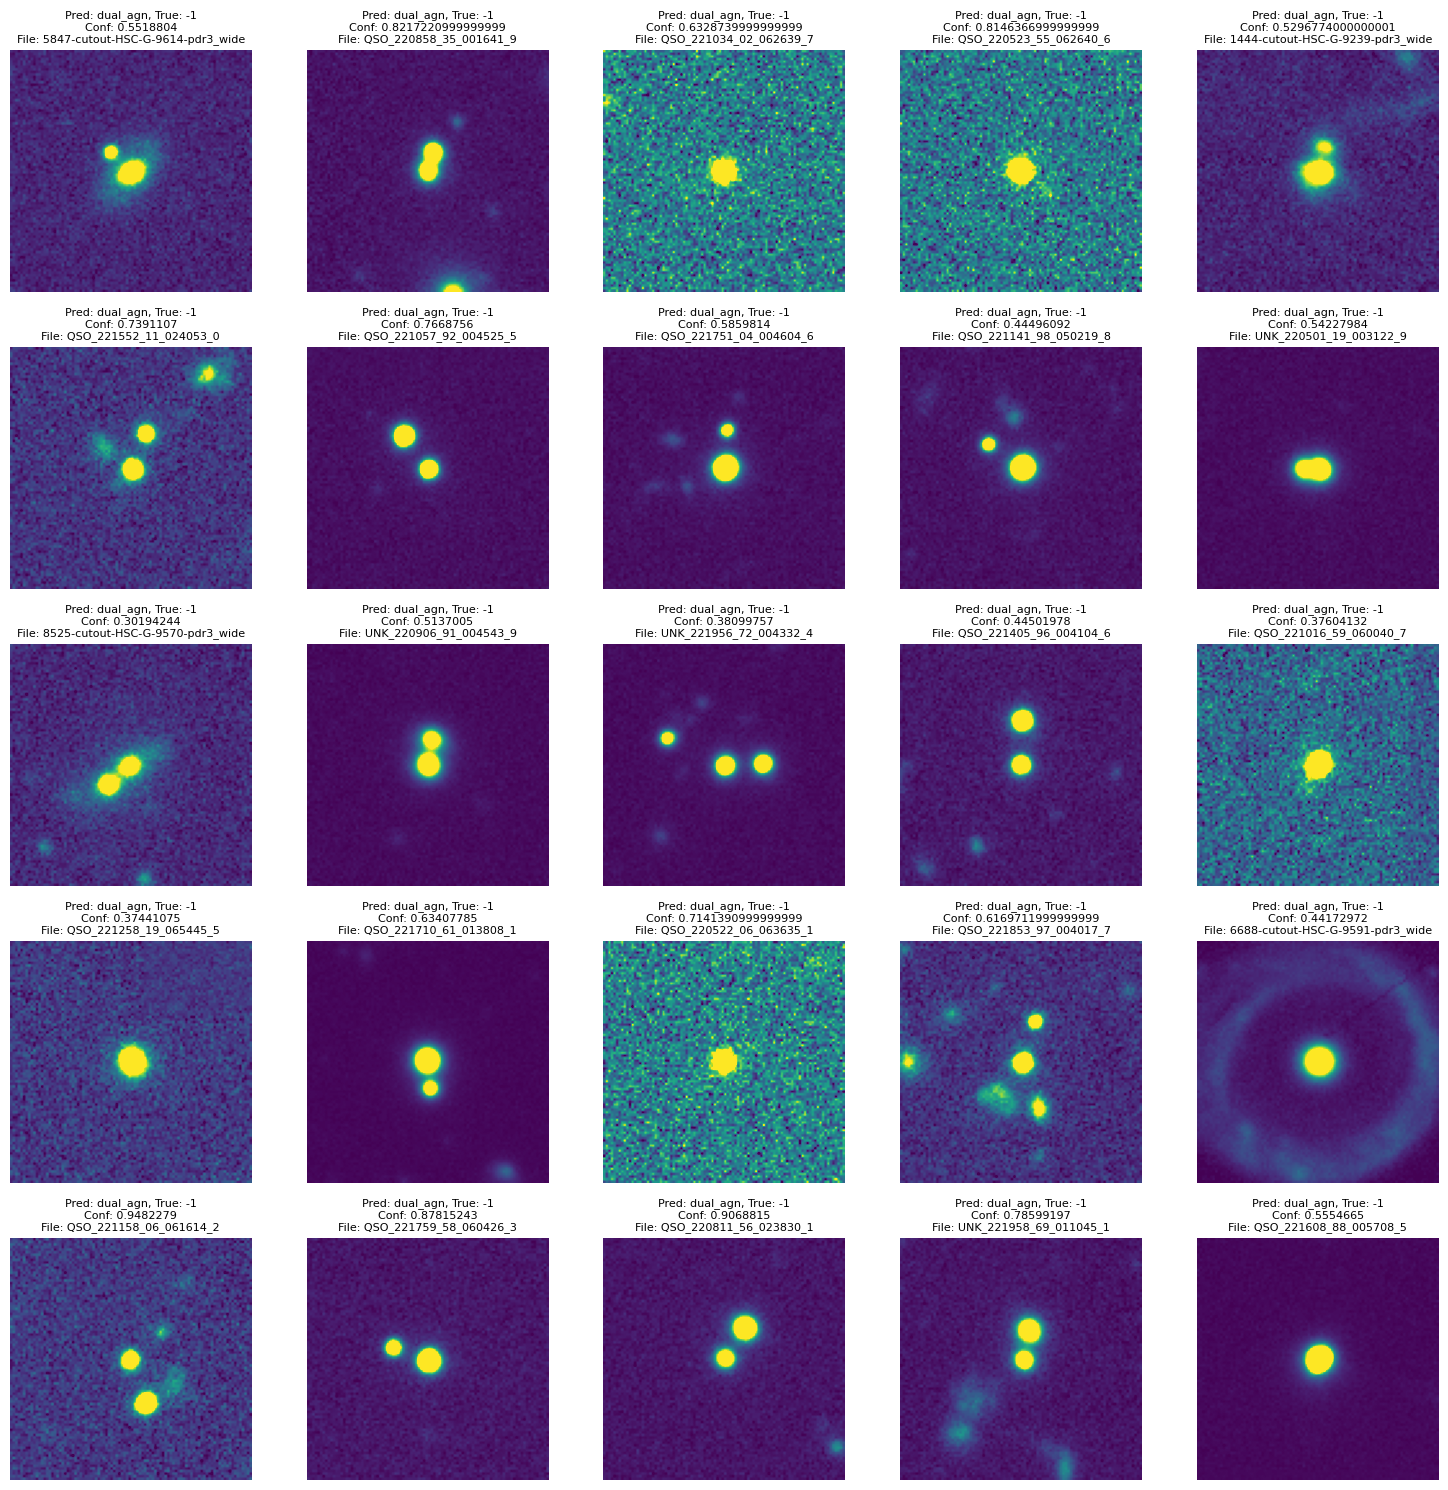

In [20]:
# For all images in general
criterion = lambda i: (pred_labels[i] == 'dual_agn')

desired_indices = [i for i in range(len(fits_images)) if criterion(i)]
desired_images = [fits_images[i] for i in desired_indices]
desired_image_files = [image_files[i] for i in desired_indices]
desired_pred_labels = [pred_labels[i] for i in desired_indices]
desired_true_labels = [true_labels[i] for i in desired_indices]
desired_pred_confidences = [pred_confidences[i] for i in desired_indices]

num_images = min(len(desired_images), 25)
random_offset_selection = np.random.choice(len(desired_images), size=num_images, replace=False)

# Determine the grid size
grid_size = int(np.ceil(np.sqrt(num_images)))

fig, axes = plt.subplots(grid_size, grid_size, figsize=(15, 15))
axes = axes.flatten()

for i in range(num_images):
    idx = random_offset_selection[i]
    img = desired_images[idx]
    img_name = Path(desired_image_files[idx]).stem
    
    ax = axes[i]
    ax.imshow(img, vmin=np.percentile(img, 1), vmax=np.percentile(img, 99), cmap='viridis')
    ax.set_title(f"Pred: {desired_pred_labels[idx]}, True: {desired_true_labels[idx]}\nConf: {desired_pred_confidences[idx]}\nFile: {img_name}", fontsize=8)
    ax.axis('off')

# Turn off any unused axes if num_images < grid_size^2
for j in range(num_images, grid_size * grid_size):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

<h1>AGN Cross Checker</h1>
<p>Here, we cross check with the 6 known dual AGN candidates and see which ones were accurately classifed.</p>

In [10]:
csv = 'inf_1.csv'
os.chdir('/vast/palmer/scratch/urry/jen55/DRAGON_CNN_NEW/DRAGON_CNN/')
df = pd.read_csv(os.path.join("hsc_2626_test_HSC-G", csv))

CANDIDATES = set(["220906_91", "221115_06", "222057_44", "220718_43", "220811_56"])
for _, row in df.iterrows():
    filename = row["file_name"]
    filename = filename.split("_")
    
    cand = "_".join([filename[1], filename[2]])
    if cand in CANDIDATES:
        print(row)
        
print(df["predicted_labels"].value_counts())

Unnamed: 0                                      632
file_name               QSO_220811_56_023830_1.fits
labels                                          NaN
predicted_labels                                  5
predicted_confidence                       0.921159
Name: 632, dtype: object
Unnamed: 0                                     2413
file_name               UNK_220718_43_001723_1.fits
labels                                          NaN
predicted_labels                                  4
predicted_confidence                       0.426385
Name: 2413, dtype: object
Unnamed: 0                                     2439
file_name               UNK_220906_91_004543_9.fits
labels                                          NaN
predicted_labels                                  5
predicted_confidence                        0.53711
Name: 2439, dtype: object
Unnamed: 0                                     2478
file_name               UNK_221115_06_000030_9.fits
labels                                 